The question that I try to answer here, is to find a simple model to predict truck travelled distance between two locations based on the shortest distance between them. The data that we have is a csv file of the location of plants, a csv file of customer's location. A csv file of historic travels between plants and customers. We want to predict the distance for those pairs we do not have data for.


## Import libraries

In [83]:
import pandas as pd
import numpy as np

from geopy.distance import distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score,  mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, cross_val_predict



from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
    Ridge
)
from sklearn.metrics import mean_absolute_error

## Import data files

Let's read the data files

In [3]:
plants = pd.read_csv('plants2.csv')
plants.head()

,plant,lat_plant,lon_plant
0,plant_1,42.142478,-82.767944
1,plant_2,34.240845,-91.383426
2,plant_3,32.765674,-92.726484
3,plant_4,34.761577,-98.483023
4,plant_5,33.125264,-99.225366


In [4]:
customers = pd.read_csv('customers2.csv')
customers.head()

,customer,lat_cust,lon_cust,cust_loc
0,customer_1,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
1,customer_2,34.045329,-104.146559,"[-104.14655867535417, 34.045328769219594]"
2,customer_3,38.008776,-81.852771,"[-81.85277146802052, 38.00877605660633]"
3,customer_4,33.648772,-86.025302,"[-86.02530175312035, 33.648771968569385]"
4,customer_5,32.648383,-104.643170,"[-104.64316989524293, 32.64838291798267]"


In [5]:
df = pd.read_csv('historic_data.csv')
df.head()

,plant,customer,distance
0,plant_1,customer_1,843.18
1,plant_1,customer_2,1252.82
2,plant_1,customer_5,1304.46
3,plant_1,customer_14,901.05
4,plant_1,customer_15,510.35


## Data cleaning

Let's find average of historic milages and add the location of plants and customers

In [6]:
df = df.merge(plants, left_on='plant', right_on='plant')
df.head()

,plant,customer,distance,lat_plant,lon_plant
0,plant_1,customer_1,843.18,42.142478,-82.767944
1,plant_1,customer_2,1252.82,42.142478,-82.767944
2,plant_1,customer_5,1304.46,42.142478,-82.767944
3,plant_1,customer_14,901.05,42.142478,-82.767944
4,plant_1,customer_15,510.35,42.142478,-82.767944


In [7]:
df = df.merge(customers, left_on='customer', right_on='customer')
df.head()

,plant,customer,distance,lat_plant,lon_plant,lat_cust,lon_cust,cust_loc
0,plant_1,customer_1,843.18,42.142478,-82.767944,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
1,plant_3,customer_1,426.32,32.765674,-92.726484,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
2,plant_5,customer_1,160.12,33.125264,-99.225366,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
3,plant_10,customer_1,994.55,36.172684,-84.722734,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
4,plant_1,customer_2,1252.82,42.142478,-82.767944,34.045329,-104.146559,"[-104.14655867535417, 34.045328769219594]"


In [8]:
df.shape

(450, 8)

In [9]:
df.drop(columns=['cust_loc'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   plant      450 non-null    object 
 1   customer   450 non-null    object 
 2   distance   450 non-null    float64
 3   lat_plant  450 non-null    float64
 4   lon_plant  450 non-null    float64
 5   lat_cust   450 non-null    float64
 6   lon_cust   450 non-null    float64
dtypes: float64(5), object(2)
memory usage: 28.1+ KB


Lets find the shortest distance between points by using distance from geopy

In [11]:
## Lets find geodesc distance
df['geo_distance'] = np.nan
for index, row in df.iterrows():
    point1 = [row['lat_plant'], row['lon_plant']]
    point2 = [row['lat_cust'], row['lon_cust']]
    df.loc[index,'geo_distance'] = distance(point1, point2).miles

In [12]:
df.head(4)

,plant,customer,distance,lat_plant,lon_plant,lat_cust,lon_cust,geo_distance
0,plant_1,customer_1,843.18,42.142478,-82.767944,33.11961,-97.400205,1013.066488
1,plant_3,customer_1,426.32,32.765674,-92.726484,33.11961,-97.400205,272.644352
2,plant_5,customer_1,160.12,33.125264,-99.225366,33.11961,-97.400205,105.838246
3,plant_10,customer_1,994.55,36.172684,-84.722734,33.11961,-97.400205,751.577091


Let's see how the data look and if a corelation is seen.  

Text(0, 0.5, 'Distance (mile)')

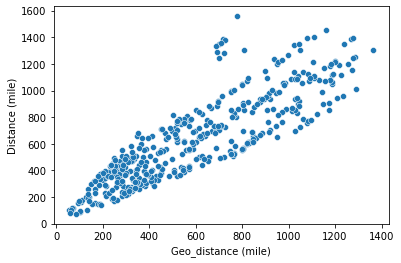

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(y=df['distance'], x=df['geo_distance'], ax=ax)
ax.set_xlabel('Geo_distance (mile)')
ax.set_ylabel('Distance (mile)')

There seems to be a nice linear relation between geo-distance and real travelled distance. However, there is also outliers, which should be addressed before doing a regression!

## Eliminate Outliers by Robust Regression

I will use two robust regression, RANSAC and Huber, to illustrate outliers. 

C:\Users\somfl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


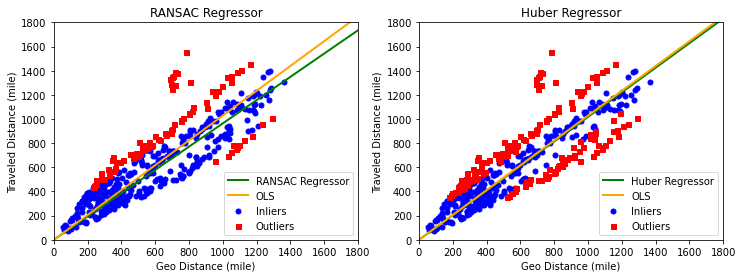

In [123]:
estimators = [
    ("RANSAC Regressor", RANSACRegressor(estimator=LinearRegression(fit_intercept=False), random_state=42)),
    ("Huber Regressor", HuberRegressor(fit_intercept=False)),
]
lw = 2
fig, [ax0, ax1]=plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for name, estimator in estimators:
    X = df['geo_distance'].values.reshape(-1, 1)
    y = df['distance'].values.reshape(-1, 1)
    final = estimator.fit(X,y)
    y_pred = estimator.predict(X)
    y_true = y
    value = mean_squared_error(y_true, y_pred)
    
    line_X = np.arange(0,1800,1)
    line_y = final.predict(line_X.reshape(-1,1))
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X,y)
    line_y_ols = reg.predict(line_X.reshape(-1,1))    
    if name=="RANSAC Regressor":
     
        inlier_mask = final.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        AX=ax0

    else:
        outlier_mask = final.outliers_
        inlier_mask = np.logical_not(outlier_mask)
        AX=ax1

    AX.plot(line_X, line_y, color='green', lw=lw, label=name)

    AX.scatter(x=X[inlier_mask], y=y[inlier_mask], c='blue', marker='o', s=25, label='Inliers')
    AX.scatter(x=X[outlier_mask], y=y[outlier_mask], c='red', marker='s', s=25, label='Outliers')

    
    AX.plot(line_X, line_y_ols, color='orange', lw=lw, label='OLS')
   
    AX.set_xlim([0,1800])
    AX.set_ylim([0,1800])
    AX.set_title(name)
    AX.set_xlabel('Geo Distance (mile)')
    AX.set_ylabel('Traveled Distance (mile)')
    AX.legend()





In each graph, the orange line is the ordinary least square line and the green line is the robust regressor used, which in the left graph is RANSAC and in the right graph is Huber. red points are those data points marked as outlier by the robust regressor and the blue points are inliers. As illustrated, Huber regressor has flagged more data points as outliers and its outcome is closer to the OLS model. On the other hand RANSAC has flagged less number of points as outliers and resulted in a line with a more detectable difference from OLS.

##  Squared Error

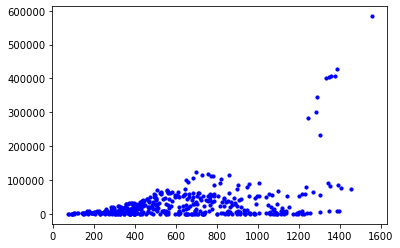

In [98]:
fig, ax = plt.subplots()
XX=y
yy = np.square(XX - y_pred.reshape(-1,1))

ax.scatter(XX, yy, s=10, color='blue', label='squared error')

##  Absolute Error

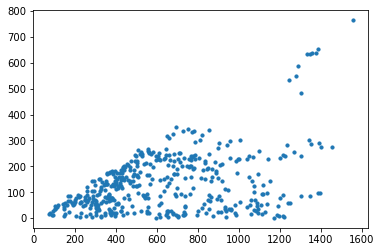

In [99]:
fig, ax = plt.subplots()
XX=y
yy = np.abs(XX - y_pred.reshape(-1,1))

ax.scatter(XX, yy, s=10)

## Model training

We split the data into two sets, training and test. Then use cross-validation with 5 fold to do a regression. we then find R2 and mean MAE

In [124]:
X=X[inlier_mask]
X.shape
y=y[inlier_mask]
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
model = LinearRegression(fit_intercept=False)
kfold = KFold(n_splits=5, shuffle = False)

cv_results = cross_validate(model, X_train, y_train, cv = kfold, scoring='r2', \
                            return_estimator=True, return_indices=True)
cv_scores = cv_results['test_score']
print(cv_scores)
final_model = model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_r2 = round(r2_score(y_train, y_train_pred), 2)
test_r2 = round(r2_score(y_test, y_test_pred), 2)
print('train R2:', train_r2)
print('test R2: ', test_r2)

[0.93588977 0.94890735 0.9506589  0.9442702  0.92844949]
train R2: 0.94
test R2:  0.92


The R2 for test and train are very similar. The model is not overfitting. Let's use it to predict the distance between plants and customers. But first lets see what pair we don't have data for.

No handles with labels found to put in legend.


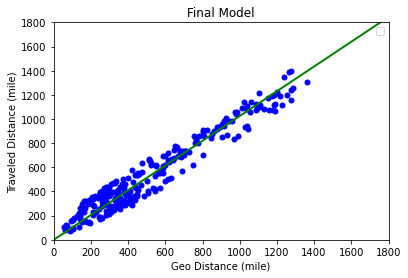

In [128]:
fig, ax = plt.subplots()
line_X = np.arange(0,1800,1)
line_y = final_model.predict(line_X.reshape(-1,1))

ax.plot(line_X, line_y, color='green', lw=lw)

ax.scatter(x=X, y=y, c='blue', marker='o', s=25)
    

ax.set_xlim([0,1800])
ax.set_ylim([0,1800])
ax.set_title('Final Model')
ax.set_xlabel('Geo Distance (mile)')
ax.set_ylabel('Traveled Distance (mile)')
ax.legend()

## Prediction

In [129]:
df['plant_customer'] = [str(x) + '**' + str(y) for x, y in zip(df['plant'], df['customer'])]
all_pair = []
for plant_name in plants['plant'].unique():
    for customer in customers['customer']:
        pair = plant_name + '**' + customer
        all_pair.append(pair)
        
unavailable_pairs = list(set(all_pair) - set(all_pair).intersection(set(df['plant_customer'])))

unavailable = pd.DataFrame()
unavailable['plant'] = [pair.split('**')[0] for pair in unavailable_pairs]
unavailable['customer'] = [pair.split('**')[1] for pair in unavailable_pairs]

unavailable = unavailable.merge(plants, on='plant', how='left')
unavailable = unavailable.merge(customers, on='customer', how='left')


unavailable['geo_distance'] = np.nan
for index, row in unavailable.iterrows():
    
    point1 = [row['lat_plant'], row['lon_plant']]
    point2 = [row['lat_cust'], row['lon_cust']]
    unavailable.loc[index,'geo_distance'] = distance(point1, point2).miles
X = unavailable['geo_distance'].values.reshape(-1,1)

prediction = final_model.predict(X)
unavailable['distance'] = prediction
for_submit = unavailable[['plant', 'customer', 'distance']]
for_submit.to_excel('report.xlsx', index=False)